In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import pymysql
import os
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import warnings

In [2]:
# ✅ 1. Database Connection Setup
DB_USER = "root"
DB_PASSWORD = "ortonfan007!"
DB_HOST = "localhost"
DB_PORT = "3306"
DB_NAME = "ptcl_inventory"
connection_string = f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)


In [3]:

# ✅ 2. Load Processed Tables
sheet1_df = pd.read_sql("SELECT * FROM processed_sheet1", con=engine)


In [4]:
sto1_df = pd.read_sql("SELECT * FROM processed_sto1", con=engine)

In [4]:
# ✅ 3. Initial Structure Check
print("--- Sheet1 ---")
sheet1_df.info()
print("\n--- STO1 ---")
sto1_df.info()

--- Sheet1 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   plant                 2450 non-null   object 
 1   storage_location      2450 non-null   object 
 2   purchase_order        2450 non-null   object 
 3   material              2450 non-null   int64  
 4   material_description  2450 non-null   object 
 5   quantity              2450 non-null   float64
 6   posting_date          2337 non-null   object 
 7   movement_type         2450 non-null   int64  
 8   amt_in_loc_cur        2450 non-null   float64
 9   entry_date            2337 non-null   object 
 10  ingestion_date        2450 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 210.7+ KB

--- STO1 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 13 columns):
 #   Column                Non

In [ ]:
# Basic shape
#print("Sheet1 rows:", sheet1_df.shape)
print("STO1 rows:", sto1_df.shape)
print("STO1 Columns:\n", sto1_df.columns)

# First few rows
#sheet1_df.head()
#print("\nSTO1 Sample:\n", sto1_df.head())
sto1_df.head()


In [ ]:
print("Sheet1 rows:", sheet1_df.shape)
print("Sheet1 Columns:\n", sheet1_df.columns)
print("\nSheet1 Sample:\n", sheet1_df.head())
sheet1_df.head(10)

In [ ]:
# 4. NULL VALUES CHECK
# ------------------------------
print("\nSheet1 Nulls:\n", sheet1_df.isnull().sum())
print("\nSTO1 Nulls:\n", sto1_df.isnull().sum())

In [36]:
# For sheet1_df
movement_summary_sheet1 = sheet1_df.groupby('movement_type')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

# For sto1_df
movement_summary_sto1 = sto1_df.groupby('movement_type')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)


In [38]:
print("Movement Type Summary (Sheet1):")
print(movement_summary_sheet1)

print("\nMovement Type Summary (STO1):")
print(movement_summary_sto1)


Movement Type Summary (Sheet1):
   movement_type   quantity
0            101  315000.83
1            201  303978.77

Movement Type Summary (STO1):
   movement_type   quantity
0            301  631595.15


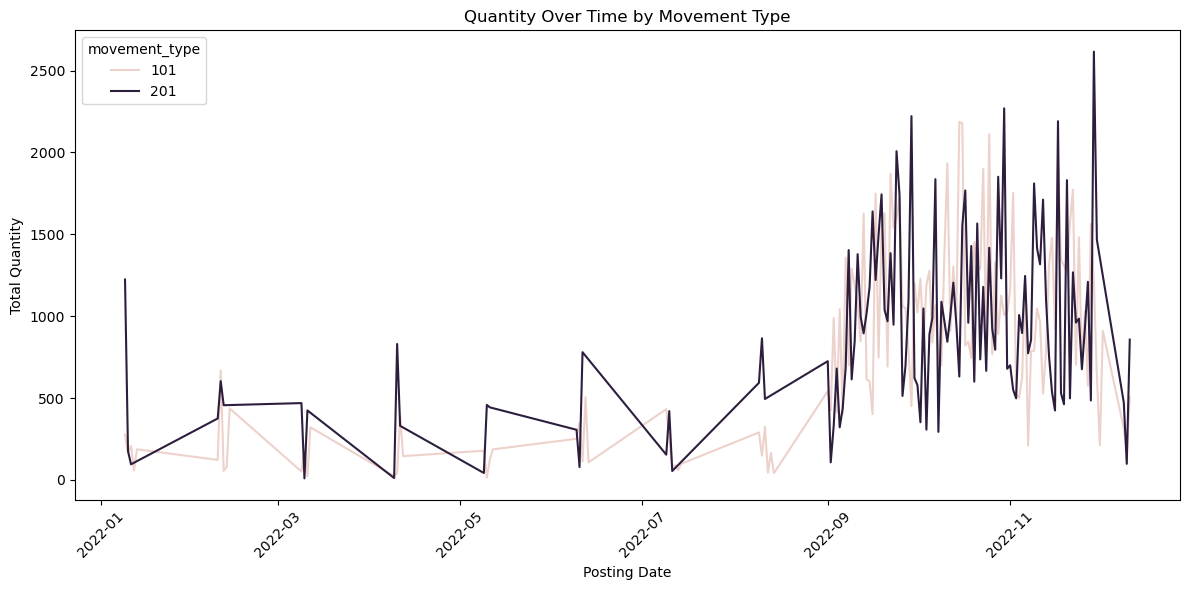

In [5]:
sheet1_df_filtered = sheet1_df.dropna(subset=['posting_date'])

# Group by movement_type and posting_date
trend = (
    sheet1_df_filtered
    .groupby(['posting_date', 'movement_type'])['quantity']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(data=trend, x='posting_date', y='quantity', hue='movement_type')
plt.title("Quantity Over Time by Movement Type")
plt.xlabel("Posting Date")
plt.ylabel("Total Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: title={'center': ' Materials by Quantity'}, xlabel='material_description'>

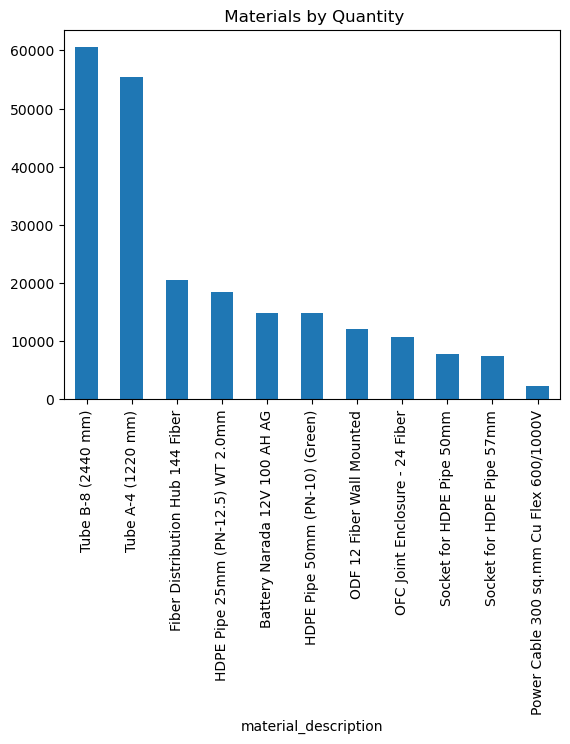

In [6]:
top_materials = (
    sheet1_df.groupby('material_description')['quantity']
    .sum().sort_values(ascending=False).head(15)
)
top_materials.plot(kind='bar', title=' Materials by Quantity')


<Axes: title={'center': 'Avg Amount by Plant'}, ylabel='plant'>

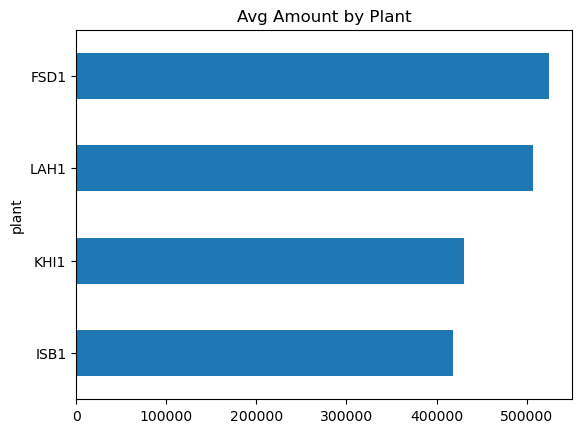

In [7]:
sheet1_df.groupby('plant')['amt_in_loc_cur'].mean().sort_values().plot(kind='barh', title='Avg Amount by Plant')


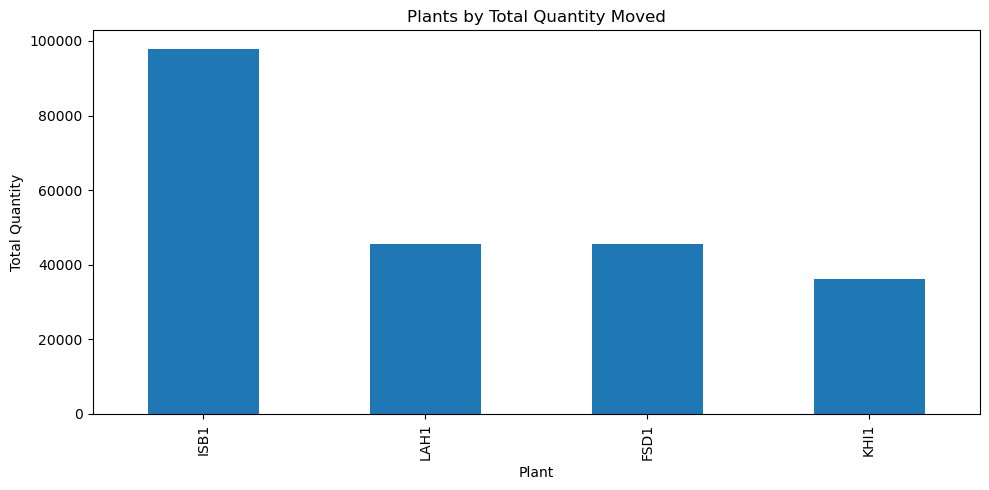

In [9]:
top_plants = sheet1_df.groupby('plant')['quantity'].sum().sort_values(ascending=False).head(10)

# Plot
top_plants.plot(kind='bar', title='Plants by Total Quantity Moved', figsize=(10, 5))
plt.ylabel('Total Quantity')
plt.xlabel('Plant')
plt.tight_layout()
plt.show()


In [ ]:
# Ensure posting_date is in datetime format
sheet1_df['posting_date'] = pd.to_datetime(sheet1_df['posting_date'], errors='coerce')

# Now group by month
monthly_demand = (
    sheet1_df
    .dropna(subset=['posting_date'])  # remove rows with invalid dates
    .assign(month=lambda df: df['posting_date'].dt.to_period('M'))  # extract month
    .groupby(['plant', 'material', 'month'])
    .agg({'quantity': 'sum'})
    .reset_index()
)

monthly_demand['month'] = monthly_demand['month'].astype(str)

print(monthly_demand.head(150))



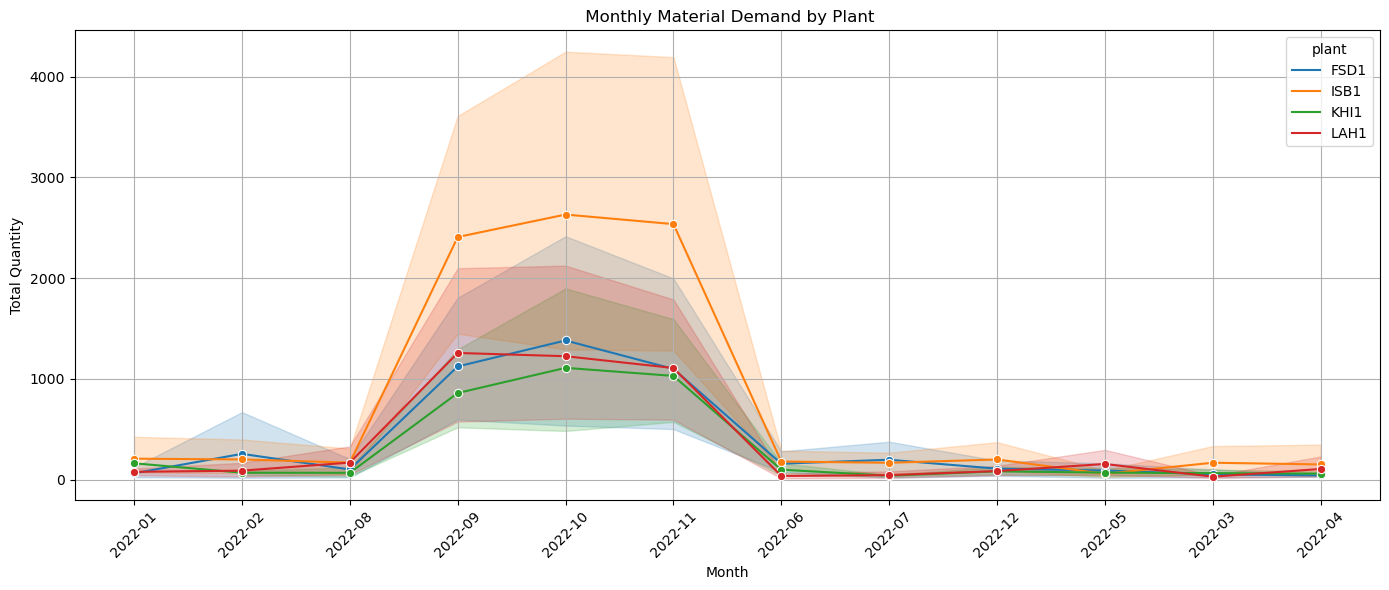

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: make sure month is in string format for cleaner x-axis
monthly_demand['month'] = monthly_demand['month'].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=monthly_demand,
    x='month',
    y='quantity',
    hue='plant',
    marker='o'
)

plt.title(' Monthly Material Demand by Plant')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Step 1: Ensure posting_date is in datetime format
sheet1_df['posting_date'] = pd.to_datetime(sheet1_df['posting_date'], errors='coerce')

# Step 2: Extract month as datetime
sheet1_df['month'] = sheet1_df['posting_date'].dt.to_period('M').dt.to_timestamp()

# ✅ FIX: Group by plant and material too
monthly_demand = (
    sheet1_df
    .dropna(subset=['posting_date'])
    .groupby(['plant', 'material', 'month'])
    .agg({'quantity': 'sum'})
    .reset_index()
    .sort_values(by='month')
)


In [15]:
import numpy as np

# Assume lead time in days = 10 (could be dynamic later)
lead_time_days = 10
daily_demand_std = sheet1_df.groupby(['plant', 'material'])['quantity'].std() / 30

safety_stock = 1.65 * daily_demand_std * lead_time_days
print("Safety stock per plant-material pair:")
print(safety_stock.head(20))


Safety stock per plant-material pair:
plant  material
FSD1   41000001    96.377255
       41000002    69.448942
       47003925     8.682327
       47003926     7.933106
       47003960    19.023516
       50000127    15.014774
       50000601     1.618337
       50006123     5.385027
       50006124    11.835191
       50006125    14.713834
       50006126     5.307853
ISB1   41000001    81.679096
       41000002    87.241373
       47003925    15.195316
       47003926    22.626323
       47003960    20.485743
       50000127    19.405113
       50000601     3.613055
       50006123     6.963255
       50006124    24.926643
Name: quantity, dtype: float64


In [ ]:
sto1_df['transit_time_days'] = (sto1_df['gr_posting_date'] - sto1_df['deliv_date']).dt.days

transit_summary = (
    sto1_df
    .dropna(subset=['transit_time_days'])
    .groupby(['plant', 'receiving_plant'])
    .agg(avg_transit=('transit_time_days', 'mean'), std_transit=('transit_time_days', 'std'))
    .reset_index()
)

print(transit_summary.head())


In [42]:
avg_daily_demand = sheet1_df.groupby([ 'plant','material'])['quantity'].mean() / 30

reorder_point = (avg_daily_demand * lead_time_days) + safety_stock
reorder_point = reorder_point.reset_index(name='reorder_point')

print(reorder_point.head())


  plant  material  reorder_point
0  AN66  41000001     166.273196
1  AN66  41000002     154.833456
2  AN66  47003925     172.976279
3  AN66  47003926     166.460517
4  AN66  47003960     164.552876


# final ANALYSIS


In [33]:
summary = sheet1_df.groupby(['plant', 'material', 'movement_type'])['quantity'].sum().unstack(fill_value=0)
summary['net_available'] = summary.get(101, 0) - summary.get(201, 0)
summary = summary.reset_index()
print(summary.head(50))


movement_type plant  material       101      201  net_available
0              FSD1  41000001   7029.79   8538.0       -1508.21
1              FSD1  41000002   5308.35   4876.0         432.35
2              FSD1  47003925    678.00    695.0         -17.00
3              FSD1  47003926    900.00    909.0          -9.00
4              FSD1  47003960   1957.00   2142.0        -185.00
5              FSD1  50000127   1899.00   2128.0        -229.00
6              FSD1  50000601    161.00    148.0          13.00
7              FSD1  50006123    902.00    792.0         110.00
8              FSD1  50006124   1265.00    723.0         542.00
9              FSD1  50006125   1632.00   1228.0         404.00
10             FSD1  50006126    728.00    794.0         -66.00
11             ISB1  41000001  11859.55   9697.0        2162.55
12             ISB1  41000002  13685.60  15269.0       -1583.40
13             ISB1  47003925   1960.00   3274.0       -1314.00
14             ISB1  47003926   2590.00 

In [34]:
# Top 5 materials
top_materials = sheet1_df[sheet1_df['movement_type'] == 201] \
    .groupby('material')['quantity'].sum() \
    .sort_values(ascending=False).head(5)
#print(top_materials)

# Get unique material-description pairs
material_desc = sheet1_df[['material', 'material_description']].drop_duplicates()

# Merge with top 5
top_materials_desc = pd.merge(top_materials, material_desc, on='material', how='left')

# Display result
print(top_materials_desc[['material', 'material_description', 'quantity']])



   material               material_description  quantity
0  41000001                 Tube B-8 (2440 mm)   29653.0
1  41000002                 Tube A-4 (1220 mm)   27206.0
2  50006125  HDPE Pipe 25mm (PN-12.5) WT 2.0mm    8997.0
3  47003960   Fiber Distribution Hub 144 Fiber    8350.0
4  50000127       Battery Narada 12V 100 AH AG    7933.0


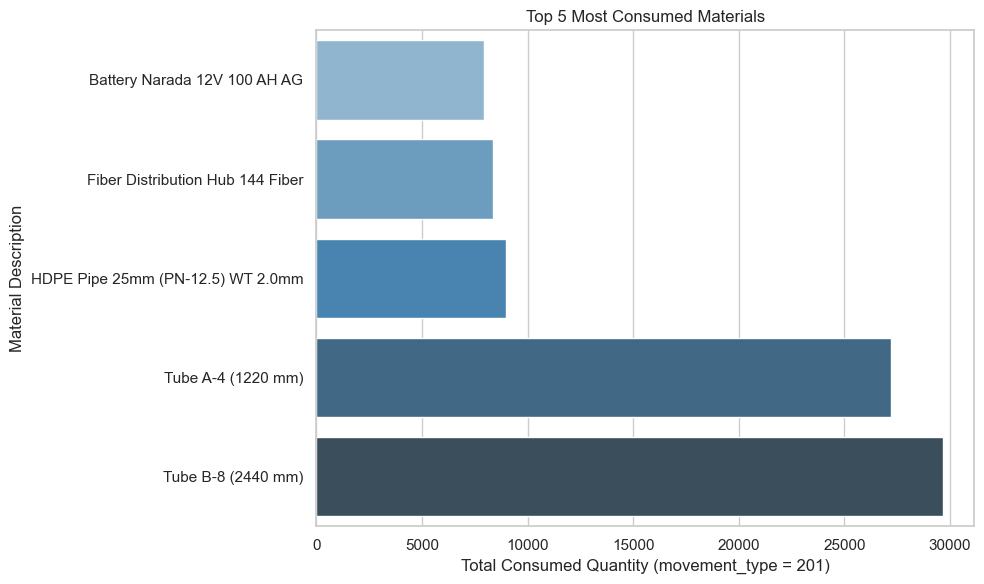

In [35]:


# Sort so largest is at the top
top_materials_desc_sorted = top_materials_desc.sort_values(by='quantity', ascending=True)

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='quantity',
    y='material_description',
    data=top_materials_desc_sorted,
    palette='Blues_d'
)

plt.xlabel("Total Consumed Quantity (movement_type = 201)")
plt.ylabel("Material Description")
plt.title("Top 5 Most Consumed Materials")
plt.tight_layout()
plt.show()


In [16]:
# Filter Only 201 Movement (Consumption Data)

import pandas as pd

# Make sure your date is in datetime format
sheet1_df['posting_date'] = pd.to_datetime(sheet1_df['posting_date'])

# Filter only movement_type = 201 (consumption)
consumption_df = sheet1_df[sheet1_df['movement_type'] == 201].copy()

# Reset index if needed
consumption_df.reset_index(drop=True, inplace=True)

# Preview the result
consumption_df.head()


,plant,storage_location,purchase_order,material,material_description,quantity,posting_date,movement_type,amt_in_loc_cur,entry_date,ingestion_date,month
0,KHI1,MAIN,PO812365,50006124,HDPE Pipe 50mm (PN-10) (Green),24.0,2022-09-13,201,14196.0,2022-09-13,2025-06-26,2022-09-01
1,FSD1,MAIN,PO383054,50006123,Socket for HDPE Pipe 57mm,53.0,2022-09-25,201,10906.0,2022-09-25,2025-06-26,2022-09-01
2,FSD1,MAIN,PO726208,50000127,Battery Narada 12V 100 AH AG,120.0,2022-05-10,201,4083760.0,2022-05-10,2025-06-26,2022-05-01
3,FSD1,MAIN,PO386121,50006123,Socket for HDPE Pipe 57mm,20.0,2022-11-10,201,4101.0,2022-11-10,2025-06-26,2022-11-01
4,KHI1,MAIN,PO161371,50000127,Battery Narada 12V 100 AH AG,76.0,2022-09-11,201,2575990.0,2022-09-11,2025-06-26,2022-09-01


In [17]:
# Extract date (drop time component)
consumption_df['date'] = consumption_df['posting_date'].dt.date

# Group by plant, material, and date → sum quantity
daily_demand = (
    consumption_df.groupby(['plant', 'material', 'date'])['quantity']
    .sum()
    .reset_index(name='daily_qty')
)

daily_demand.head()


,plant,material,date,daily_qty
0,FSD1,41000001,2022-01-09,180.0
1,FSD1,41000001,2022-02-10,196.0
2,FSD1,41000001,2022-08-11,293.0
3,FSD1,41000001,2022-09-03,142.0
4,FSD1,41000001,2022-09-08,356.0


In [18]:
# Filter only 101 (goods receipt)
receipts_df = sheet1_df[sheet1_df['movement_type'] == 101].copy()

# Make sure date columns are datetime
receipts_df['entry_date'] = pd.to_datetime(receipts_df['entry_date'])
receipts_df['posting_date'] = pd.to_datetime(receipts_df['posting_date'])

# Calculate lead time
receipts_df['lead_time_days'] = (receipts_df['posting_date'] - receipts_df['entry_date']).dt.days

# Group by plant/material to get average lead time
avg_lead_time = (
    receipts_df.groupby(['plant', 'material'])['lead_time_days']
    .mean()
    .reset_index()
    .rename(columns={'lead_time_days': 'avg_lead_time_days'})
)

avg_lead_time.head()



,plant,material,avg_lead_time_days
0,FSD1,41000001,1.000000
1,FSD1,41000002,0.818182
2,FSD1,47003925,0.461538
3,FSD1,47003926,0.476190
4,FSD1,47003960,0.300000


In [19]:
# Group by plant-material → calculate mean and std of daily demand
demand_stats = (
    daily_demand.groupby(['plant', 'material'])['daily_qty']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'avg_daily_demand', 'std': 'std_dev_demand'})
)

# Merge lead time into demand stats
demand_stats = demand_stats.merge(avg_lead_time, on=['plant', 'material'], how='left')

# Replace missing lead time (e.g., no 101 found) with default fallback
demand_stats['avg_lead_time_days'].fillna(3, inplace=True)


demand_stats.head()


,plant,material,avg_daily_demand,std_dev_demand,avg_lead_time_days
0,FSD1,41000001,341.520000,232.075799,1.000000
1,FSD1,41000002,218.150000,112.964025,0.818182
2,FSD1,47003925,28.045455,14.254414,0.461538
3,FSD1,47003926,41.571429,28.361191,0.476190
4,FSD1,47003960,112.833333,42.403177,0.300000


In [21]:


# Define constant for 95% service level
z_score = 1.65

# Calculate safety stock using correct syntax
demand_stats['safety_stock'] = (
    z_score * demand_stats['std_dev_demand'] * np.sqrt(demand_stats['avg_lead_time_days'])
).round()

# Preview result
demand_stats[['plant', 'material', 'avg_daily_demand', 'std_dev_demand', 'avg_lead_time_days', 'safety_stock']].head()




,plant,material,avg_daily_demand,std_dev_demand,avg_lead_time_days,safety_stock
0,FSD1,41000001,341.520000,232.075799,1.000000,383.0
1,FSD1,41000002,218.150000,112.964025,0.818182,169.0
2,FSD1,47003925,28.045455,14.254414,0.461538,16.0
3,FSD1,47003926,41.571429,28.361191,0.476190,32.0
4,FSD1,47003960,112.833333,42.403177,0.300000,38.0


In [22]:
# Recalculate safety stock safely
z_score = 1.65

# Ensure 'avg_lead_time_days' is present
assert 'avg_lead_time_days' in demand_stats.columns, "Missing lead time column!"

# Create safety_stock column
demand_stats['safety_stock'] = (
    z_score * demand_stats['std_dev_demand'] * np.sqrt(demand_stats['avg_lead_time_days'])
).round()

In [20]:
print(demand_stats.columns)


Index(['plant', 'material', 'avg_daily_demand', 'std_dev_demand',
       'avg_lead_time_days'],
      dtype='object')


In [23]:
# Calculate Reorder Point
demand_stats['reorder_point'] = (
    demand_stats['avg_daily_demand'] * demand_stats['avg_lead_time_days'] + 
    demand_stats['safety_stock']
).round()




In [290]:
#Preview the result
print(demand_stats[['plant', 'material', 'avg_daily_demand', 'avg_lead_time_days', 'safety_stock', 'reorder_point']].head())

  plant  material  avg_daily_demand  avg_lead_time_days  safety_stock  \
0  FSD1  41000001        341.520000            1.000000         383.0   
1  FSD1  41000002        218.150000            0.818182         169.0   
2  FSD1  47003925         28.045455            0.461538          16.0   
3  FSD1  47003926         41.571429            0.476190          32.0   
4  FSD1  47003960        112.833333            0.300000          38.0   

   reorder_point  
0          725.0  
1          347.0  
2           29.0  
3           52.0  
4           72.0  


In [24]:
# Step 1: Calculate total consumption per plant-material
top3_by_plant = (
    consumption_df.groupby(['plant', 'material'])['quantity']
    .sum()
    .reset_index()
)

# Step 2: Get top 3 materials per plant using groupby + rank
top3_by_plant['rank'] = (
    top3_by_plant.groupby('plant')['quantity']
    .rank(method='first', ascending=False)
)

# Step 3: Filter only top 3
top_3_materials_per_plant = top3_by_plant[top3_by_plant['rank'] <= 3]

# Final result: a list of (plant, material) pairs
critical_pairs = top_3_materials_per_plant[['plant', 'material']].values.tolist()


In [46]:
print(critical_pairs)

[['FSD1', 41000001], ['FSD1', 41000002], ['FSD1', 47003960], ['ISB1', 41000001], ['ISB1', 41000002], ['ISB1', 50006125], ['KHI1', 41000001], ['KHI1', 41000002], ['KHI1', 47003960], ['LAH1', 41000001], ['LAH1', 41000002], ['LAH1', 47003960]]


In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
forecast_horizon = 4  # 30 days
forecast_output = []

for plant, material in critical_pairs:
    mat_df = consumption_df[(consumption_df['plant'] == plant) & 
                            (consumption_df['material'] == material)]

    ts = (
        mat_df.set_index('posting_date')
        .resample('W')['quantity']
        .sum()
        .asfreq('D')  # ⬅️ This line removes the warning
        .fillna(0)
    )
    
    if len(ts) >= 30:
        try:
            model = ExponentialSmoothing(ts, trend='add', seasonal=None).fit()
            pred = model.forecast(forecast_horizon)

            residual_std = model.resid.std()
            lower = pred - 1.65 * residual_std
            upper = pred + 1.65 * residual_std

            forecast_output.append(pd.DataFrame({
                'plant': plant,
                'material': material,
                'forecast_date': pred.index,
                'forecast_qty': pred.values,
                'lower_95ci': lower,
                'upper_95ci': upper
            }))
        except:
            continue


In [30]:
# Combine all forecast DataFrames into one
forecast_df = pd.concat(forecast_output, ignore_index=True)

forecast_df['lower_95ci'] = forecast_df['lower_95ci'].clip(lower=0)


# Preview the first few rows
print(forecast_df.head(50))


   plant  material forecast_date  forecast_qty  lower_95ci  upper_95ci
0   FSD1  41000001    2022-12-05     85.533467         0.0  321.708759
1   FSD1  41000001    2022-12-06     85.860987         0.0  322.036280
2   FSD1  41000001    2022-12-07     86.188507         0.0  322.363800
3   FSD1  41000001    2022-12-08     86.516027         0.0  322.691320
4   FSD1  41000002    2022-11-28      0.188037         0.0  223.292527
5   FSD1  41000002    2022-11-29     -0.346354         0.0  222.758136
6   FSD1  41000002    2022-11-30     -0.880745         0.0  222.223745
7   FSD1  41000002    2022-12-01     -1.415135         0.0  221.689355
8   FSD1  47003960    2022-12-12     19.996288         0.0  162.989487
9   FSD1  47003960    2022-12-13     20.732395         0.0  163.725593
10  FSD1  47003960    2022-12-14     21.468501         0.0  164.461700
11  FSD1  47003960    2022-12-15     22.204608         0.0  165.197807
12  ISB1  41000001    2022-12-05     74.917884         0.0  352.003498
13  IS

In [28]:
def forecast_prophet(consumption_df, plant_id, material_id):
    mat_df = consumption_df[
        (consumption_df['plant'] == plant_id) & 
        (consumption_df['material'] == material_id)
    ]
    
    ts = (
        mat_df.set_index('posting_date')
        .resample('W')['quantity']
        .sum()
        .fillna(0)
    )
    
    df_prophet = ts.reset_index().rename(columns={'posting_date': 'ds', 'quantity': 'y'})
    
    if df_prophet['y'].notnull().sum() < 2:
        print(f"⛔ Skipped: Not enough data for {plant_id}, {material_id}")
        return None
    
    model = Prophet()
    model.fit(df_prophet)
    
    future = model.make_future_dataframe(periods=4, freq='W')
    forecast = model.predict(future)
    
    forecast_output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    forecast_output['plant'] = plant_id
    forecast_output['material'] = material_id
    
    return forecast_output.tail(4)


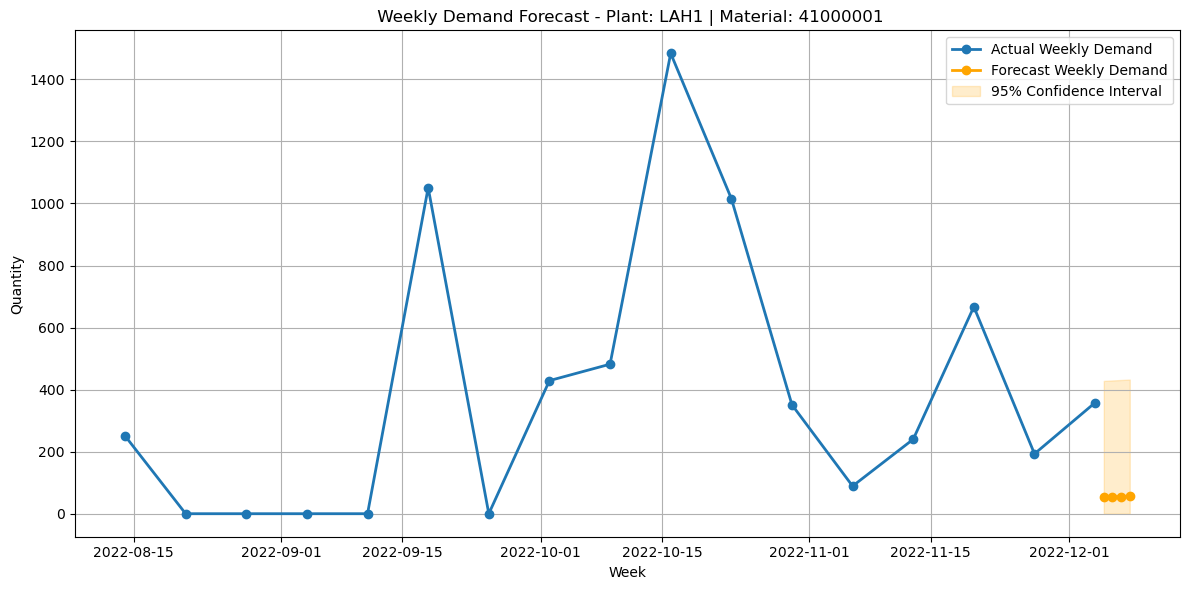

In [29]:

import matplotlib.pyplot as plt

# Set your test values (must match forecast_df)
plant_id = 'LAH1'
material_id = '41000001'

# Make sure plant and material are strings
forecast_df['plant'] = forecast_df['plant'].astype(str)
forecast_df['material'] = forecast_df['material'].astype(str)
consumption_df['plant'] = consumption_df['plant'].astype(str)
consumption_df['material'] = consumption_df['material'].astype(str)

# Filter forecast data
forecast_plot_df = forecast_df[
    (forecast_df['plant'] == plant_id) & 
    (forecast_df['material'] == material_id)
]

# Filter actual weekly data
actual_df = (
    consumption_df[(consumption_df['plant'] == plant_id) & 
                   (consumption_df['material'] == material_id)]
    .set_index('posting_date')
    .resample('W')['quantity']
    .sum()
    .fillna(0)
    .reset_index()
)

# ✅ Safety check before plotting
if forecast_plot_df.empty:
    print(f" No forecast found for plant '{plant_id}', material '{material_id}'")
elif actual_df.empty:
    print(f" No actual consumption found for plant '{plant_id}', material '{material_id}'")
else:
    # 📈 Plot forecast vs actual
    plt.figure(figsize=(12, 6))

    # Actual demand
    plt.plot(actual_df['posting_date'], actual_df['quantity'], 
             label='Actual Weekly Demand', marker='o', linewidth=2)

    # Forecasted demand
    plt.plot(forecast_plot_df['forecast_date'], forecast_plot_df['forecast_qty'], 
             label='Forecast Weekly Demand', color='orange', marker='o', linewidth=2)

    # Confidence interval
    plt.fill_between(forecast_plot_df['forecast_date'],
                     forecast_plot_df['lower_95ci'].clip(lower=0),
                     forecast_plot_df['upper_95ci'],
                     color='orange', alpha=0.2, label='95% Confidence Interval')

    plt.title(f" Weekly Demand Forecast - Plant: {plant_id} | Material: {material_id}")
    plt.xlabel("Week")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [59]:
forecast_df[['plant', 'material']].drop_duplicates().head(10)


,plant,material
0,FSD1,41000001
4,FSD1,41000002
8,FSD1,47003960
12,ISB1,41000001
16,ISB1,41000002
20,ISB1,50006125
24,KHI1,41000001
28,KHI1,41000002
32,KHI1,47003960
36,LAH1,41000001


In [31]:
print("Forecast Data Preview:")
print(forecast_df[
    (forecast_df['plant'] == plant_id) & 
    (forecast_df['material'] == material_id)
].head())

print("\nActual Data Preview:")
print(actual_df.head())


Forecast Data Preview:
Empty DataFrame
Columns: [plant, material, forecast_date, forecast_qty, lower_95ci, upper_95ci]
Index: []

Actual Data Preview:
  posting_date  quantity
0   2022-08-14     251.0
1   2022-08-21       0.0
2   2022-08-28       0.0
3   2022-09-04       0.0
4   2022-09-11       0.0


In [32]:
print("forecast_df exists:", 'forecast_df' in globals())
print("demand_stats exists:", 'demand_stats' in globals())
print("consumption_df exists:", 'consumption_df' in globals())


forecast_df exists: True
demand_stats exists: True
consumption_df exists: True


In [33]:
# Forecast dates
print("forecast_date type:", forecast_df['forecast_date'].dtype)

# Posting date in consumption
print("posting_date type:", consumption_df['posting_date'].dtype)


forecast_date type: datetime64[ns]
posting_date type: datetime64[ns]


In [34]:
print("forecast_df columns:", forecast_df.columns.tolist())
print("demand_stats columns:", demand_stats.columns.tolist())
print("consumption_df columns:", consumption_df.columns.tolist())


forecast_df columns: ['plant', 'material', 'forecast_date', 'forecast_qty', 'lower_95ci', 'upper_95ci']
demand_stats columns: ['plant', 'material', 'avg_daily_demand', 'std_dev_demand', 'avg_lead_time_days', 'safety_stock', 'reorder_point']
consumption_df columns: ['plant', 'storage_location', 'purchase_order', 'material', 'material_description', 'quantity', 'posting_date', 'movement_type', 'amt_in_loc_cur', 'entry_date', 'ingestion_date', 'month', 'date']


In [35]:
import pandas as pd
import os

# Define the export path
export_folder = r"C:\Users\Maaz\Desktop\PTCL_Inventory_Project\dashboard_data"
os.makedirs(export_folder, exist_ok=True)  # Ensure the folder exists

output_path = os.path.join(export_folder, "PTCL_Forecasting_Dashboard.xlsx")

# Export to Excel with multiple sheets
with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    forecast_df.to_excel(writer, sheet_name='ForecastData', index=False)
    demand_stats.to_excel(writer, sheet_name='DemandStats', index=False)
    consumption_df[['plant', 'material', 'posting_date', 'quantity']].to_excel(writer, sheet_name='ActualConsumption', index=False)

print("Export complete:", output_path)


Export complete: C:\Users\Maaz\Desktop\PTCL_Inventory_Project\dashboard_data\PTCL_Forecasting_Dashboard.xlsx


In [278]:
dup_check = demand_stats.groupby(['plant', 'material']).size().reset_index(name='count')
dup_check = dup_check[dup_check['count'] > 1]
print(dup_check)


Empty DataFrame
Columns: [plant, material, count]
Index: []


In [36]:
import pandas as pd

# Ensure date column is datetime
consumption_df['posting_date'] = pd.to_datetime(consumption_df['posting_date'])

# Create a new 'month' column
consumption_df['month'] = consumption_df['posting_date'].dt.to_period('M').astype(str)

# Group by material and month
pivot_df = (
    consumption_df
    .groupby(['material', 'month'])['quantity']
    .sum()
    .reset_index()
    .pivot(index='material', columns='month', values='quantity')
    .fillna(0)
    .astype(int)  # Optional: convert to int for clean output
)

# Preview the table
print(pivot_df.head())


month     2022-01  2022-02  2022-03  2022-04  2022-05  2022-06  2022-07  \
material                                                                  
41000001      180      196      394        0        0        0        0   
41000002      751      494      211      614        0      460      267   
47003925       38        0        0      185      125       64        0   
47003926       20      211        0        0       53       60        0   
47003960        0       96        0      111      296      133        0   

month     2022-08  2022-09  2022-10  2022-11  2022-12   NaT  
material                                                     
41000001      544     7805    10717     9138        0   679  
41000002      813     6461     7443     7782      689  1221  
47003925       76     1518     1527     1847      102   397  
47003926        0     2194     1518     1876        0   667  
47003960       23     2662     2031     2067      285   646  


In [8]:
pivot_df.to_excel("monthly_material_summary.xlsx")


# croston

In [39]:
# croston

def croston(ts, forecast_periods=4, alpha=0.1):
    demand = np.array(ts)
    n = len(demand)

    q = np.zeros(n)
    a = np.zeros(n)
    p = np.zeros(n)

    first = np.argmax(demand > 0)
    
    # Safety: No non-zero demand at all
    if demand[first] == 0:
        return np.repeat(0, forecast_periods)

    q[first] = demand[first]
    a[first] = demand[first]
    p[first] = 1
    last_demand = first

    for t in range(first + 1, n):
        if demand[t] > 0:
            q[t] = alpha * demand[t] + (1 - alpha) * q[t-1]
            p[t] = alpha * (t - last_demand) + (1 - alpha) * p[t-1]
            a[t] = q[t] / p[t]
            last_demand = t
        else:
            q[t] = q[t-1]
            p[t] = p[t-1]
            a[t] = a[t-1]

    forecast = np.repeat(a[-1], forecast_periods)
    return forecast



In [45]:
import pandas as pd
import numpy as np

# --- 1️⃣ Robust Croston function with empty/zero guards ---
def croston(ts, forecast_periods=4, alpha=0.1):
    demand = np.array(ts)
    n = len(demand)
    
    # 1. No history at all → flat zero forecast
    if n == 0:
        return np.zeros(forecast_periods)
    # 2. All zeros → flat zero forecast
    if demand.max() == 0:
        return np.zeros(forecast_periods)
    
    # 3. Find first positive demand
    first = np.argmax(demand > 0)
    
    # Initialize series
    q = np.zeros(n)
    p = np.zeros(n)
    a = np.zeros(n)
    last_demand = first
    
    # Seed initial values at first occurrence
    q[first] = demand[first]
    p[first] = 1
    a[first] = q[first] / p[first]
    
    # Update through history
    for t in range(first+1, n):
        if demand[t] > 0:
            q[t] = alpha * demand[t] + (1 - alpha) * q[t-1]
            p[t] = alpha * (t - last_demand) + (1 - alpha) * p[t-1]
            last_demand = t
        else:
            q[t] = q[t-1]
            p[t] = p[t-1]
        a[t] = q[t] / p[t]
    
    # Forecast = last a[t] repeated
    return np.repeat(a[-1], forecast_periods)


# --- 2️⃣ Your end‑to‑end code for one plant/material ---
plant_id = 'LAH1'
material_id = 41000001  # as integer

# Filter your real data
test_df = consumption_df[
    (consumption_df['plant'] == plant_id) &
    (consumption_df['material'] == material_id)
].copy()

# Ensure datetime index
test_df['posting_date'] = pd.to_datetime(test_df['posting_date'])

# Aggregate weekly consumption
weekly_ts = (
    test_df
    .set_index('posting_date')['quantity']
    .resample('W')
    .sum()
    .fillna(0)
)

# Forecast next 4 weeks using robust Croston
croston_forecast = croston(weekly_ts, forecast_periods=4)

# Prepare the future dates
last_date = weekly_ts.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                             periods=4, freq='W')

# Build forecast DataFrame
forecast_df_croston = pd.DataFrame({
    'forecast_date': future_dates,
    'forecast_qty': croston_forecast,
    'plant': plant_id,
    'material': material_id
})

print(forecast_df_croston)



  forecast_date  forecast_qty plant  material
0    2022-12-11    364.122126  LAH1  41000001
1    2022-12-18    364.122126  LAH1  41000001
2    2022-12-25    364.122126  LAH1  41000001
3    2023-01-01    364.122126  LAH1  41000001


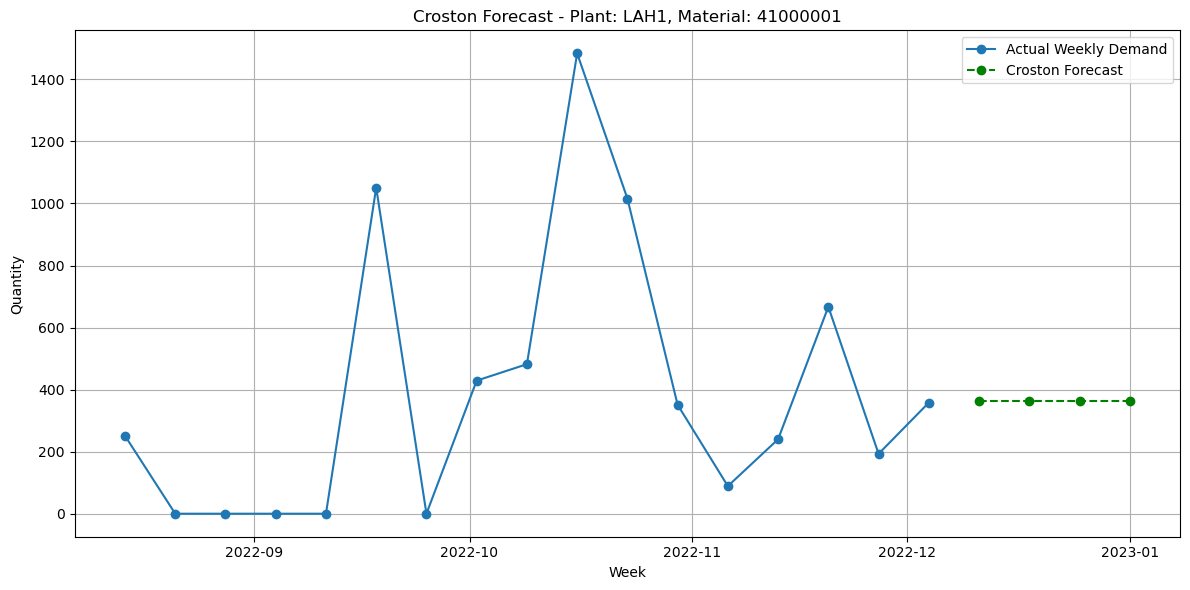

In [46]:
plt.figure(figsize=(12, 6))

# Plot actual
plt.plot(weekly_ts.index, weekly_ts.values, label='Actual Weekly Demand', marker='o')

# Plot Croston forecast
plt.plot(forecast_df_croston['forecast_date'], forecast_df_croston['forecast_qty'],
         label='Croston Forecast', marker='o', linestyle='--', color='green')

plt.title(f'Croston Forecast - Plant: {plant_id}, Material: {material_id}')
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
actual_y = weekly_ts[-4:]
forecast_y = np.repeat(croston_forecast[0], len(actual_y))  # constant forecast

errors = actual_y - forecast_y
error_std = np.std(errors)
from scipy.stats import norm

z = norm.ppf(0.975)  # for 95% confidence
lower_bound = forecast_y - z * error_std
upper_bound = forecast_y + z * error_std


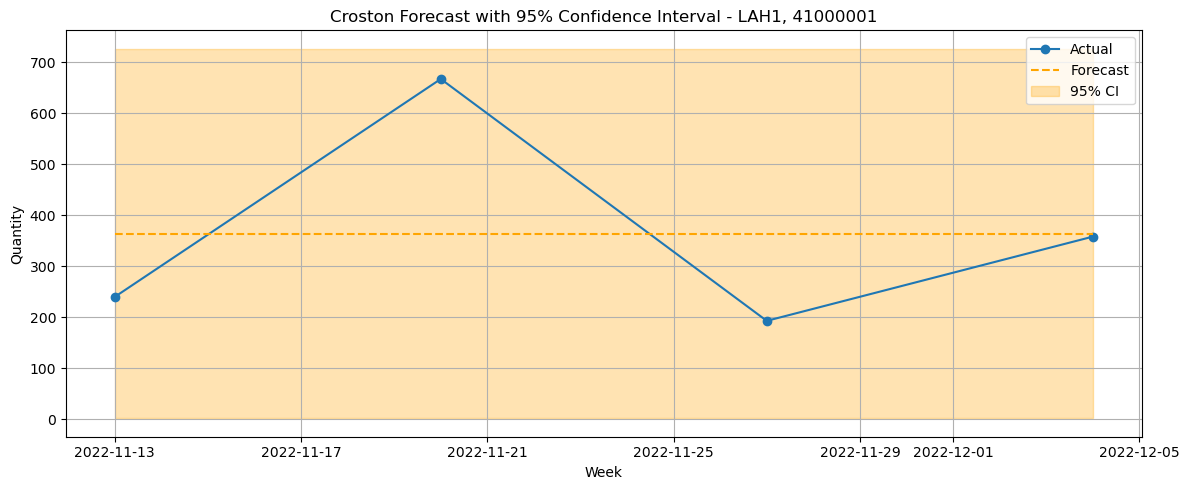

In [48]:
# Plot forecast with confidence interval
plt.figure(figsize=(12,5))
plt.plot(actual_y.index, actual_y.values, label='Actual', marker='o')
plt.plot(actual_y.index, forecast_y, label='Forecast', linestyle='--', color='orange')
plt.fill_between(actual_y.index, lower_bound, upper_bound, color='orange', alpha=0.3, label='95% CI')
plt.title(f"Croston Forecast with 95% Confidence Interval - {plant_id}, {material_id}")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
y_true = weekly_ts[-4:]  # last 4 weeks of actuals
y_pred_croston = croston_forecast  # already 4 values


In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
    return mae, rmse, mape

# Evaluate Croston forecast
mae_croston, rmse_croston, mape_croston = evaluate_forecast(y_true, y_pred_croston)

print("\n🧪 Croston Forecast Accuracy:")
print(f"MAE  : {mae_croston:.2f}")
print(f"RMSE : {rmse_croston:.2f}")
print(f"MAPE : {mape_croston:.2f}%")



🧪 Croston Forecast Accuracy:
MAE  : 151.06
RMSE : 184.70
MAPE : 46.88%


# Recalculate safety stock and reorder point for forecaste weeks using croston

In [52]:
# Add average daily forecasted demand
forecast_df_croston['forecast_daily_demand'] = forecast_df_croston['forecast_qty'] / 7


In [53]:
# Calculate forecast std dev (week-to-week fluctuation)
forecast_std = (
    forecast_df_croston
    .groupby(['plant', 'material'])['forecast_daily_demand']
    .std()
    .reset_index()
    .rename(columns={'forecast_daily_demand': 'forecast_std_dev'})
)


In [54]:
# Merge lead time with forecast std dev
forecast_inputs = pd.merge(
    forecast_std,
    demand_stats[['plant', 'material', 'avg_lead_time_days']],
    on=['plant', 'material'],
    how='left'
)


## Compute Forecast-Based Safety Stock

In [55]:
z_score = 1.65

forecast_inputs['forecast_safety_stock'] = (
    z_score * forecast_inputs['forecast_std_dev'] * 
    np.sqrt(forecast_inputs['avg_lead_time_days'])
).round()


## Compute Forecast-Based Reorder Point

In [56]:
# Calculate average forecasted daily demand per item
avg_forecast = (
    forecast_df_croston
    .groupby(['plant', 'material'])['forecast_daily_demand']
    .mean()
    .reset_index()
    .rename(columns={'forecast_daily_demand': 'avg_forecast_daily_demand'})
)

# Merge with forecast_inputs
final_forecast = pd.merge(forecast_inputs, avg_forecast, on=['plant', 'material'], how='left')

# Final reorder point calculation
final_forecast['forecast_reorder_point'] = (
    final_forecast['avg_forecast_daily_demand'] * final_forecast['avg_lead_time_days'] +
    final_forecast['forecast_safety_stock']
).round()


##  Final Output

In [57]:
final_forecast[['plant', 'material', 'avg_forecast_daily_demand', 
                'forecast_std_dev', 'avg_lead_time_days', 
                'forecast_safety_stock', 'forecast_reorder_point']].head()


,plant,material,avg_forecast_daily_demand,forecast_std_dev,avg_lead_time_days,forecast_safety_stock,forecast_reorder_point
0,LAH1,41000001,52.017447,0.0,0.580645,0.0,30.0


##  compare this forecast-based safety stock and reorder point to your historical values:

In [58]:
# Join both historical and forecast metrics
compare_df = pd.merge(
    demand_stats[['plant', 'material', 'safety_stock', 'reorder_point']],
    final_forecast[['plant', 'material', 'forecast_safety_stock', 'forecast_reorder_point']],
    on=['plant', 'material'],
    how='inner'
)

compare_df.head()


,plant,material,safety_stock,reorder_point,forecast_safety_stock,forecast_reorder_point
0,LAH1,41000001,299.0,525.0,0.0,30.0


# Croston TSB

In [326]:



def croston_tsb(ts, forecast_periods=4, alpha=0.1, beta=0.1):
    # Convert to numpy array
    demand = np.array(ts)
    n = len(demand)
    
    # Guard 1: no history at all
    if n == 0:
        return np.zeros(forecast_periods)
    
    # Guard 2: all zeros → flat zero forecast
    if demand.max() == 0:
        return np.zeros(forecast_periods)
    
    # Safe to find first positive
    first = np.argmax(demand > 0)
    
    # Initialize
    q = np.zeros(n)
    p = np.zeros(n)
    f = np.zeros(n)
    
    q[first] = demand[first]
    p[first] = 1.0
    f[first] = q[first] * p[first]
    
    last_demand = first
    
    for t in range(first+1, n):
        if demand[t] > 0:
            q[t] = alpha * demand[t] + (1 - alpha) * q[t-1]
            p[t] = beta * 1 + (1 - beta) * p[t-1]
            last_demand = t
        else:
            q[t] = q[t-1]
            p[t] = (1 - beta) * p[t-1]
        f[t] = q[t] * p[t]
    
    # Final forecast value
    forecast_value = f[-1]
    return np.repeat(forecast_value, forecast_periods)


In [327]:
forecast_periods = 4
tsb_forecast = croston_tsb(weekly_ts, forecast_periods=forecast_periods)
print(tsb_forecast)


[372.38577454 372.38577454 372.38577454 372.38577454]


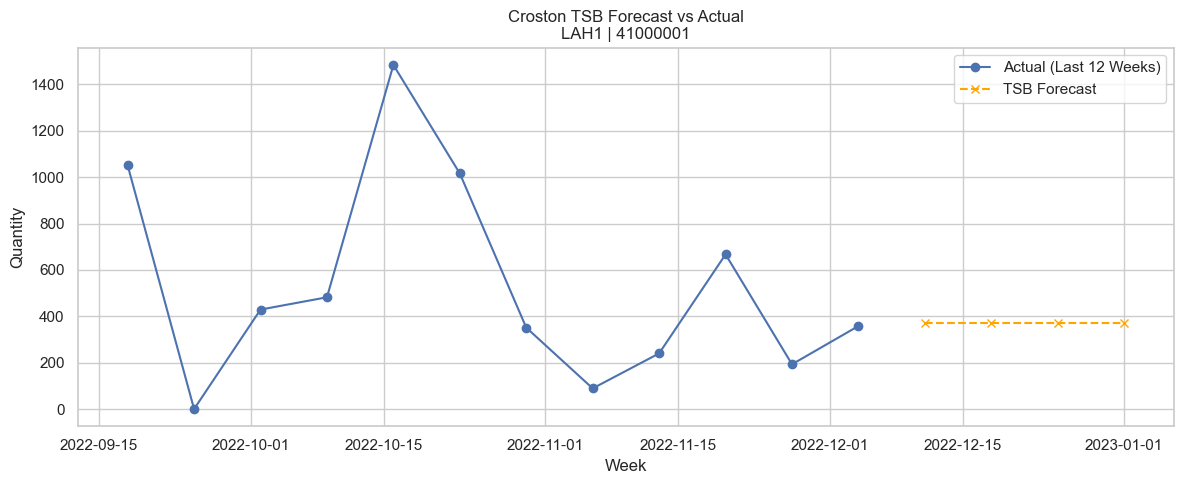

In [328]:
# After building weekly_ts…
if weekly_ts.empty:
    print(f"No weekly data for {plant_id}, {material_id}, skipping plot.")
else:
    # Safe to get last_date and plot
    last_date = weekly_ts.index[-1]
    forecast_dates = pd.date_range(
        start=last_date + pd.Timedelta(weeks=1),
        periods=forecast_periods,
        freq='W'
    )

    plt.figure(figsize=(12, 5))
    # Plot only if we have at least 1 point
    if len(weekly_ts) >= 12:
        plt.plot(
            weekly_ts.index[-12:], 
            weekly_ts.values[-12:], 
            label='Actual (Last 12 Weeks)', 
            marker='o'
        )
    else:
        plt.plot(
            weekly_ts.index, 
            weekly_ts.values, 
            label='Actual', 
            marker='o'
        )

    plt.plot(forecast_dates, tsb_forecast, 
             label='TSB Forecast', 
             marker='x', linestyle='--', color='orange')

    plt.title(f"Croston TSB Forecast vs Actual\n{plant_id} | {material_id}")
    plt.xlabel("Week")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [329]:
sub_df = consumption_df[
    (consumption_df['plant'] == plant_id) &
    (consumption_df['material'] == material_id) &
    (consumption_df['movement_type'] == 201)
].copy()

if sub_df.empty:
    print(f"❌ No data found for {plant_id}, {material_id}")
else:
    print(f"✅ Found {len(sub_df)} rows for {plant_id}, {material_id}")

    sub_df['posting_date'] = pd.to_datetime(sub_df['posting_date'])

# Weekly aggregation
weekly_ts = (
    sub_df.set_index('posting_date')['quantity']
    .resample('W')
    .sum()
    .fillna(0)
)

print("✅ weekly_ts length:", len(weekly_ts))
print(weekly_ts.tail())




✅ Found 21 rows for LAH1, 41000001
✅ weekly_ts length: 17
posting_date
2022-11-06     89.0
2022-11-13    240.0
2022-11-20    667.0
2022-11-27    193.0
2022-12-04    358.0
Name: quantity, dtype: float64


In [239]:
tsb_forecast = croston_tsb(weekly_ts, forecast_periods=4)

if len(weekly_ts) >= 8:
    tsb_forecast = croston_tsb(weekly_ts, forecast_periods=4)
    # plot or evaluate here
else:
    print(f"⚠️ Not enough data for {plant_id}, {material_id} to apply TSB (only {len(weekly_ts)} weeks)")


In [330]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1) Determine backtest window
backtest_weeks = min(4, len(weekly_ts))  # don’t exceed available history

# 2) Slice the actuals
actual_y = weekly_ts[-backtest_weeks:]

# 3) Build forecast_y of the same length
# Use the first TSB forecast value repeated, or the full vector truncated:
if len(tsb_forecast) >= backtest_weeks:
    forecast_y = tsb_forecast[:backtest_weeks]
else:
    # If tsb_forecast is shorter (or empty), fill with zeros
    forecast_y = np.repeat(tsb_forecast[0] if tsb_forecast.size else 0, backtest_weeks)

# 4) If still empty, skip evaluation
if backtest_weeks == 0:
    print("Not enough history to backtest TSB.")
else:
    mae  = mean_absolute_error(actual_y, forecast_y)
    rmse = np.sqrt(mean_squared_error(actual_y, forecast_y))
    # MAPE: avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((actual_y - forecast_y) / actual_y.replace(0, np.nan))) * 100

    print("🧪 TSB Forecast Accuracy:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAPE : {mape:.2f}%")


🧪 TSB Forecast Accuracy:
MAE  : 155.19
RMSE : 184.87
MAPE : 49.07%


In [331]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure at least 1 week exists
if len(weekly_ts) < 2:
    print("Not enough data to backtest.")
else:
    # Choose backtest length up to 8 weeks or available history
    backtest_weeks = min(8, len(weekly_ts) // 2)  # use half history up to 8
    train_ts = weekly_ts[:-backtest_weeks]
    test_ts  = weekly_ts[-backtest_weeks:]

    # Forecast the same number of weeks
    tsb_forecast = croston_tsb(train_ts, forecast_periods=backtest_weeks)

    # Align lengths
    if len(tsb_forecast) != len(test_ts):
        tsb_forecast = tsb_forecast[:len(test_ts)]
    
    # Compute metrics
    mae  = mean_absolute_error(test_ts, tsb_forecast)
    rmse = np.sqrt(mean_squared_error(test_ts, tsb_forecast))
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((test_ts - tsb_forecast) / test_ts.replace(0, np.nan))) * 100

    print("📊 Backtest Results (TSB):")
    print(f"Backtest Weeks : {backtest_weeks}")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAPE : {mape:.2f}%")


📊 Backtest Results (TSB):
Backtest Weeks : 8
MAE  : 357.73
RMSE : 542.38
MAPE : 61.25%


# ML Model


In [332]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 1. Assume `consumption_df` is already loaded

# 2. Filter for consumption movement_type == 201
df = consumption_df[consumption_df['movement_type'] == 201 ].copy()
df['posting_date'] = pd.to_datetime(df['posting_date'])

# 3. Aggregate weekly consumption per plant and material
weekly = (
    df
    .groupby(['plant', 'material', pd.Grouper(key='posting_date', freq='W')])['quantity']
    .sum()
    .reset_index()
    .sort_values(['plant','material','posting_date'])
)

# 4. Feature engineering: time features, lags, rolling mean
weekly['week']  = weekly['posting_date'].dt.isocalendar().week.astype(int)
weekly['month'] = weekly['posting_date'].dt.month.astype(int)

for lag in (1, 2, 3):
    weekly[f'lag_{lag}'] = weekly.groupby(['plant','material'])['quantity'].shift(lag)

weekly['rolling_mean_3'] = (
    weekly.groupby(['plant','material'])['quantity']
    .shift(1)
    .rolling(window=3)
    .mean()
)

# 5. Drop rows with NaNs
weekly = weekly.dropna().reset_index(drop=True)

# 6. Prepare a list to collect results
results = []

# 7. Iterate over all plant-material pairs
pairs = weekly[['plant','material']].drop_duplicates().values
for plant_id, material_id in pairs:
    sub = weekly[
        (weekly['plant'] == plant_id) & 
        (weekly['material'] == material_id)
    ].copy()
    print(f"Series for {plant_id}, {material_id} has {len(sub)} weeks of data")

    if len(sub) < 4:
        continue
    
    # 8. Train/test split: last 4 weeks as test
    cutoff = sub['posting_date'].max() - pd.Timedelta(weeks=4)
    train = sub[sub['posting_date'] <= cutoff]
    test  = sub[sub['posting_date'] >  cutoff]
    
    # 9. Define features and target
    feats = ['week','month','lag_1','lag_2','lag_3','rolling_mean_3']
    X_train, y_train = train[feats], train['quantity']
    X_test,  y_test  = test[feats],  test['quantity']
    
    # 10. Train XGBoost model
    model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    
    # 11. Predict and evaluate
    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = (np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100)
    
    # 12. Forecast next 4 weeks
    last_row = sub.iloc[-1:].copy()
    future_dates = pd.date_range(start=sub['posting_date'].max() + pd.Timedelta(weeks=1),
                                 periods=4, freq='W')
    forecast_next = []
    for d in future_dates:
        row = {
            'week': d.isocalendar()[1],
            'month': d.month,
            'lag_1': last_row['quantity'].values[0],
            'lag_2': last_row['lag_1'].values[0],
            'lag_3': last_row['lag_2'].values[0],
            'rolling_mean_3': last_row[['lag_1','lag_2','lag_3']].mean(axis=1).values[0]
        }
        q = model.predict(pd.DataFrame([row]))[0]
        forecast_next.append((d, q))
        new = pd.Series(row)
        new['quantity'] = q
        for l in (1,2,3):
            new[f'lag_{l}'] = last_row[f'lag_{l-1}'].values[0] if l>1 else last_row['quantity'].values[0]
        last_row = pd.DataFrame([new], columns=last_row.columns)
    
    results.append({
        'plant': plant_id,
        'material': material_id,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'forecast_next_4w': forecast_next
    })

# 13. Build and print summary
summary = pd.DataFrame([{
    'plant': r['plant'],
    'material': r['material'],
    'MAE': r['MAE'],
    'RMSE': r['RMSE'],
    'MAPE': r['MAPE']
} for r in results])

print("Forecast Accuracy Summary:")
print(summary)

# Example: print 4-week forecast for the first pair
first = results[0]
print(f"\nNext 4-week forecast for {first['plant']}, {first['material']}:")
for date, qty in first['forecast_next_4w']:
    print(f"{date.date()} -> {qty:.2f}")



Series for FSD1, 41000001 has 13 weeks of data
Series for FSD1, 41000002 has 7 weeks of data
Series for FSD1, 47003925 has 10 weeks of data
Series for FSD1, 47003926 has 11 weeks of data
Series for FSD1, 47003960 has 8 weeks of data
Series for FSD1, 50000127 has 14 weeks of data
Series for FSD1, 50000601 has 10 weeks of data
Series for FSD1, 50006123 has 9 weeks of data
Series for FSD1, 50006124 has 7 weeks of data
Series for FSD1, 50006125 has 7 weeks of data
Series for FSD1, 50006126 has 9 weeks of data
Series for ISB1, 41000001 has 12 weeks of data
Series for ISB1, 41000002 has 18 weeks of data
Series for ISB1, 47003925 has 13 weeks of data
Series for ISB1, 47003926 has 11 weeks of data
Series for ISB1, 47003960 has 14 weeks of data
Series for ISB1, 50000127 has 12 weeks of data
Series for ISB1, 50000601 has 17 weeks of data
Series for ISB1, 50006123 has 14 weeks of data
Series for ISB1, 50006124 has 12 weeks of data
Series for ISB1, 50006125 has 12 weeks of data
Series for ISB1, 50


=== FSD1, 41000001 ===
MAE: 466.29, RMSE: 498.68, MAPE: 95.46%
Next 4-week forecast:
  2022-12-11 -> 18.53
  2022-12-18 -> 1309.93
  2022-12-25 -> 18.53
  2023-01-01 -> 654.36


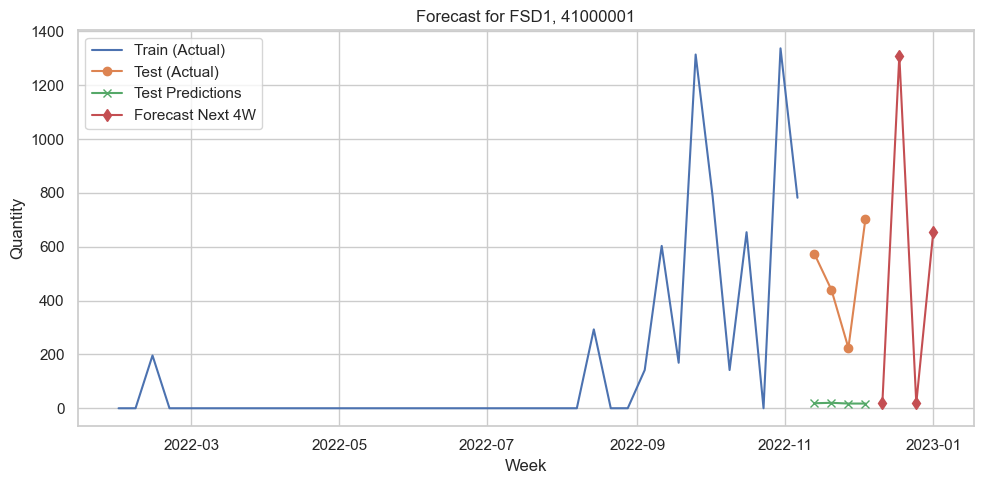


=== LAH1, 41000001 ===
MAE: 458.30, RMSE: 538.45, MAPE: 172.03%
Next 4-week forecast:
  2022-12-11 -> 91.47
  2022-12-18 -> 744.68
  2022-12-25 -> 1094.92
  2023-01-01 -> 712.84


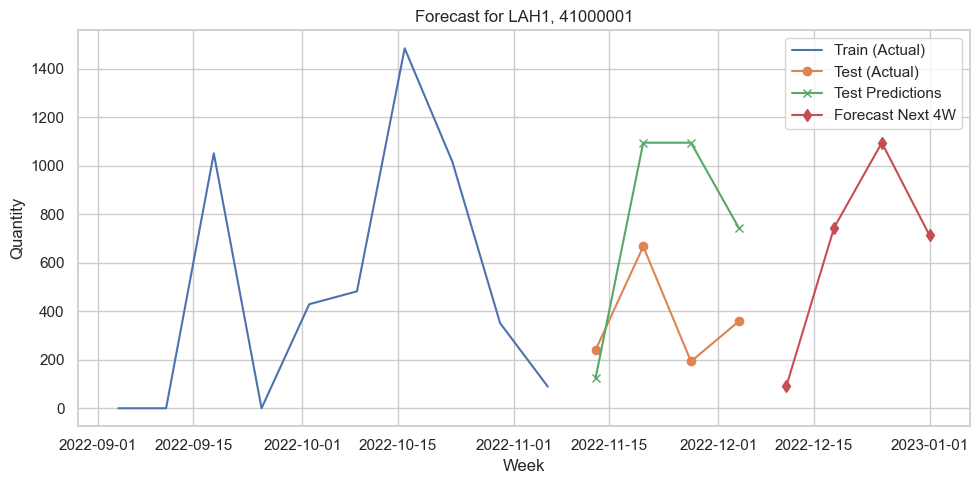

In [333]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# 1️⃣ Define your specific plant-material pairs
selected_pairs = [
    ('FSD1', 41000001),
    ('LAH1', 41000001)
]

# 2️⃣ Ensure movement_type is integer and posting_date is datetime
df = consumption_df[consumption_df['movement_type'] == 201].copy()
df['posting_date'] = pd.to_datetime(df['posting_date'])

# 3️⃣ Loop over each selected pair and forecast
for plant_id, material_id in selected_pairs:
    # a) Filter
    sub_df = df[(df['plant'] == plant_id) & (df['material'] == material_id)].copy()
    if sub_df.empty:
        print(f"No data for {plant_id}, {material_id}")
        continue

    # b) Aggregate weekly
    weekly = (
        sub_df.groupby(pd.Grouper(key='posting_date', freq='W'))['quantity']
        .sum()
        .reset_index()
        .sort_values('posting_date')
    )
    
    # c) Feature engineering
    weekly['week'] = weekly['posting_date'].dt.isocalendar().week.astype(int)
    weekly['month'] = weekly['posting_date'].dt.month.astype(int)
    for lag in [1, 2, 3]:
        weekly[f'lag_{lag}'] = weekly['quantity'].shift(lag)
    weekly['rolling_mean_3'] = weekly['quantity'].shift(1).rolling(3).mean()
    weekly.dropna(inplace=True)
    
    # d) Train/test split (last 4 weeks test)
    cutoff = weekly['posting_date'].max() - pd.Timedelta(weeks=4)
    train = weekly[weekly['posting_date'] <= cutoff]
    test = weekly[weekly['posting_date'] > cutoff]
    
    # e) Prepare features & target
    features = ['week', 'month', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3']
    X_train, y_train = train[features], train['quantity']
    X_test, y_test = test[features], test['quantity']
    
    # f) Train model
    model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    
    # g) Predict on test and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100
    
    print(f"\n=== {plant_id}, {material_id} ===")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    
    # h) Forecast next 4 weeks
    last_row = weekly.iloc[-1:].copy()
    future_dates = pd.date_range(start=weekly['posting_date'].max() + pd.Timedelta(weeks=1),
                                 periods=4, freq='W')
    forecast_next = []
    for d in future_dates:
        row = {
            'week': d.isocalendar()[1],
            'month': d.month,
            'lag_1': last_row['quantity'].values[0],
            'lag_2': last_row['lag_1'].values[0],
            'lag_3': last_row['lag_2'].values[0],
            'rolling_mean_3': last_row[['lag_1','lag_2','lag_3']].mean(axis=1).values[0]
        }
        qty = model.predict(pd.DataFrame([row]))[0]
        forecast_next.append((d, qty))
        new = pd.Series(row)
        new['quantity'] = qty
        for l in [1, 2, 3]:
            new[f'lag_{l}'] = last_row[f'lag_{l-1}'].values[0] if l > 1 else last_row['quantity'].values[0]
        last_row = pd.DataFrame([new], columns=last_row.columns)
    
    print("Next 4-week forecast:")
    for d, qty in forecast_next:
        print(f"  {d.date()} -> {qty:.2f}")
    
    # i) Plot actual vs test predictions and future forecast
    plt.figure(figsize=(10, 5))
    plt.plot(train['posting_date'], train['quantity'], label='Train (Actual)')
    plt.plot(test['posting_date'], test['quantity'], label='Test (Actual)', marker='o')
    plt.plot(test['posting_date'], y_pred, label='Test Predictions', marker='x')
    forecast_dates, forecast_vals = zip(*forecast_next)
    plt.plot(forecast_dates, forecast_vals, label='Forecast Next 4W', marker='d')
    plt.title(f"Forecast for {plant_id}, {material_id}")
    plt.xlabel("Week")
    plt.ylabel("Quantity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [44]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 0️⃣ Load your data into consumption_df...
# consumption_df = pd.read_excel(".../processed_sheet1.xlsx")

# 1️⃣ Normalize dtypes
consumption_df['movement_type'] = consumption_df['movement_type'].astype(int)
consumption_df['material']      = consumption_df['material'].astype(int)
consumption_df['plant']         = consumption_df['plant'].astype(str)
consumption_df['posting_date']  = pd.to_datetime(consumption_df['posting_date'])

# 2️⃣ Filter only actual consumption records
df = consumption_df[consumption_df['movement_type'] == 201].copy()

# ...then proceed with your weekly aggregation, feature engineering, and forecasting loop...




In [43]:

print("movement_type dtype:", consumption_df['movement_type'].dtype)
print("unique movement_types:", consumption_df['movement_type'].unique()[:5])

print("material dtype:", consumption_df['material'].dtype)
print("some materials:", consumption_df['material'].unique()[:5])

print("plant dtype:", consumption_df['plant'].dtype)
print("some plants:", consumption_df['plant'].unique()[:5])


movement_type dtype: int64
unique movement_types: [201]
material dtype: object
some materials: ['50006124' '50006123' '50000127' '50000601' '41000001']
plant dtype: object
some plants: ['KHI1' 'FSD1' 'ISB1' 'LAH1']


In [ ]:
! pip install xgboost

In [117]:
# Right before "if len(sub) < 8: continue", add:
# Instead of '201' (string), use integer 201:
df = consumption_df[consumption_df['movement_type'] == 201].copy()

print(f"{plant}, {material_id} has {len(sub)} weeks of data")


LAH1, 41000001 has 11 weeks of data


In [60]:
import pandas as pd

# Define your save path
save_path = r"C:\Users\Maaz\Desktop\PTCL_Inventory_Project\forecast_analysis_outputs.xlsx"

# Save all 3 DataFrames into one workbook
with pd.ExcelWriter(save_path, engine='xlsxwriter') as writer:
    forecast_df_croston.to_excel(writer, sheet_name='Forecast_Croston', index=False)
    demand_stats.to_excel(writer, sheet_name='Historical_Stats', index=False)
    compare_df.to_excel(writer, sheet_name='Inventory_Control', index=False)

print(f"✅ Excel file saved to:\n{save_path}")



✅ Excel file saved to:
C:\Users\Maaz\Desktop\PTCL_Inventory_Project\forecast_analysis_outputs.xlsx
